# QSOF - Task 2

This was the original problem statement:

> Implement a circuit that returns |01> and |10> with equal probability.
>
> Requirements :
- The circuit should consist only of CNOTs, RXs and RYs. 
- Start from all parameters in parametric gates being equal to 0 or randomly chosen. 
- You should find the right set of parameters using gradient descent (you can use more advanced optimization methods if you like). 
- Simulations must be done with sampling - i.e. a limited number of measurements per iteration and noise. 
>
> Compare the results for different numbers of measurements: 1, 10, 100, 1000. 
>
> Bonus question:
>
> How to make sure you produce state |01> + |10> and not |01> - |10> ?


## My approach

My understanding of the task is to use variational circuit optimisation using the specified gates and to compare the behaviour of the same circuit when different numbers of measurements are taken. 

After [reading up](https://www.mustythoughts.com/variational-quantum-eigensolver-explained) on variational methods it seems that the simplest approach is to:

1. [Create a parameterisable circuit](#1.-Designing-and-testing-the-ansatz) (ansatz) using the restricted gate set
2. [Define the target probability distribution](#2.-Define-the-target-distribution)
3. [Train the parameters](#3.-Training) using some kind of optimisation algorithm to approximate as closely as possible the target distribution.
4. [Compare results](#4.-Comparing-results) with different numbers of measurements in each optimisation run.

After setting up a suitable programming environment, this notebook goes through the above steps. I'll use QisKit since it's the Python library with which I'm most familiar. One additional constraint I'll give myself is to build the optimisation step from scratch. I've found that there is literally no better way to understand something than to build it yourself :)

The bonus question I'll attack in a [separate notebook](QOSF%20-%20Task%202%20%28Bonus%20Question%29.ipynb).

First we'll need to initialise the environment and a simulator with a suitable noise model.

# 0. Setting up the environment

In [1]:
#pip3 install qiskit, matplotlib

import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.15.1',
 'qiskit-aer': '0.6.1',
 'qiskit-ignis': '0.4.0',
 'qiskit-ibmq-provider': '0.8.0',
 'qiskit-aqua': '0.7.5',
 'qiskit': '0.20.0'}

## Initialise the simulator

Define a backend to use. We'll be sampling over a noisy circuit in order to optimise the parameters so its appropriate to use the Aer simulator.

In [2]:
from qiskit import Aer

backend = Aer.get_backend('qasm_simulator')

## Define a noise model

One of the stated aims of the task is to train in the presence of noise. Here we build a noise model for our experiment. This is taken from the QisKit [example](https://qiskit.org/documentation/apidoc/aer_noise.html) and I'm not really sure if it's realistic or not. An alternative is to use approximate noise model for a physical device. As the task indicates, we are restricted to using $RX(\theta)$, $RY(\theta)$ and $CX$ gates only.

In [3]:
import qiskit.providers.aer.noise as noise

# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.01   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['rx', 'ry'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'u3']
  Instructions with noise: ['ry', 'cx', 'rx']
  All-qubits errors: ['rx', 'ry', 'cx']


## Executing the circuit

We'll need to execute the circuit many times with different parameters to perform the optimisations. Rather than do this directly every time I'll define an `experiment()` function here to execute the circuit with the given number of measurements. 

The result counts from QisKit are returned as a dictionary with the states as the keys. I have found it helpful to extract a function which normalises those results so they can be compared easily with the the target distribution.

In [4]:
from qiskit import execute
from qiskit.visualization import plot_histogram

def normalise(counts):
    normed_distr = dict()
    total = math.sqrt(sum([c*c for c in counts.values()]))
    for key in ["00","01","10","11"]:
        normed_distr[key] = counts.get(key, 0.0)/total
    return normed_distr

def experiment(qc, shots):
    result = execute(qc, backend, noise_model=noise_model, shots=shots).result()
    return normalise(result.get_counts())

# 1. Designing and testing the ansatz

The ansatz is the parameterisable circuit which will be trained to produce the desired state. In this case we create a simple circuit using the restricted gate set and only a single CNOT. If we can't find convergence with this circuit we can always try a more complicated one.

In [5]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

def ansatz(params):
    qr = QuantumRegister(2, name="q")
    cr = ClassicalRegister(2, name='c')
    qc = QuantumCircuit(qr, cr)
    
    qc.rx(params[0], qr[0])
    qc.rx(params[1], qr[1])
    qc.ry(params[2], qr[0])
    qc.ry(params[3], qr[1])
    qc.cx(qr[0], qr[1])
    qc.measure(qr[0], cr[0])
    qc.measure(qr[1], cr[1])
    return qc

As a quick test, we can use Quirk to apply rotations of $\frac{\pi}{2}$ to see that the circuit should give equal probabilities for all possible results when measured. 

<div width="100%"><img src="test-circuit-quirk.png" align="left"/></div>

We can then plot both the circuit and the results of a large number of measurements to check them visually.

In [6]:
import math
import numpy as np

pi = math.pi

params = np.array([pi/2, pi/2, pi/2, pi/2])
qc = ansatz(params)
qc.draw()

┌──────────┐┌──────────┐     ┌─┐   
q_0: ┤ RX(pi/2) ├┤ RY(pi/2) ├──■──┤M├───
     ├──────────┤├──────────┤┌─┴─┐└╥┘┌─┐
q_1: ┤ RX(pi/2) ├┤ RY(pi/2) ├┤ X ├─╫─┤M├
     └──────────┘└──────────┘└───┘ ║ └╥┘
c: 2/══════════════════════════════╩══╩═
                                   0  1

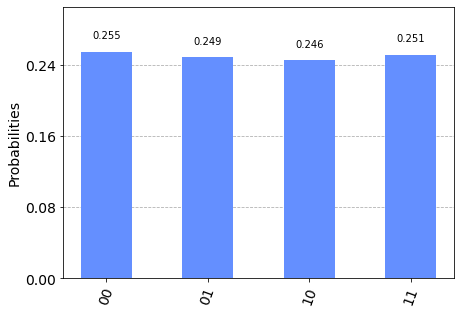

In [7]:
plot_histogram(experiment(ansatz(params), 10000))

This is exactly the result we expect!



# 2. Define the target distribution

After that preparatory work we're now in a position to tackle the problem at hand. The task is to train a circuit (the ansatz defined above) so that it returns |01> and |10> with equal probability (and no other, presumably). We define the target distribution as the normalised state with those probabilities.

In [8]:
target_distr = normalise({"01": 1, "10": 1})
print(target_distr)

{'00': 0.0, '01': 0.7071067811865475, '10': 0.7071067811865475, '11': 0.0}


## The objective function

The task asks us to train with different number of measurements to compare the difference. Intuition suggests that it will be harder to train with less measurements because the results will have higher variance. In any case we'll define that value globally so it can be changed easily.

In [9]:
number_of_measurements = 1000

A simple [objective function](https://en.wikipedia.org/wiki/Objective_function) for the training will be the [Manhatten distance](https://en.wikipedia.org/wiki/Taxicab_geometry) to the target distribution. Minimising this function should result in an ansatz that is a good approximation. There are a million other distance measure we could choose here but this one is simple and, I think, suitable for this situation. The implementation assumes that all the values are present in the distribution dict, which is the case for the normalised distributions.

In [10]:
def manhatten_distance(first_distr, second_distr):
    return sum([np.abs(first_distr[key] - second_distr[key]) for key in target_distr.keys()])

def objective_function(params):
    qc = ansatz(params)
    counts = experiment(qc, number_of_measurements)
    output_distr = normalise(counts)
    return manhatten_distance(output_distr, target_distr)

# 3. Training

The task suggests using gradient descent or some other more advanced optimisation methods to determine a good set of parameters. I'll assume the wording gives us some scope for creativity here :) The field of optimisation and machine learning provides very many ways to approach this problem which I've studied that outside of the field of quantum computing. We could leverage existing machine learning libraries with very advanced accelerated algorithms but here I would like to keep it simple and from first principles so I'll continue with SPCA which seems to be a good fit to this problem and is also simple enough to implement from scratch.

(Just for fun I've tried a couple of algorithms, from a simple random search through to advanced optimisers built into QisKit. The results are in the Appendix at the bottom of this notebook.)

## Simultaneous perturbation stochastic approximation (SPSA)

[SPSA](https://en.wikipedia.org/wiki/Simultaneous_perturbation_stochastic_approximation) is an interesting optimisation method and, according to a [QisKit tutorial](https://qiskit.org/textbook/ch-applications/vqe-molecules.html#optimization), preferred over standard gradient decent for these kinds of noisy problems.  

The advantage of this method is that it takes far fewer samples of the objective function (exactly two per step) compared to other methods with similar performance. This would become important as the number of parameters grows larger. It does have more hyperparameters that need to be tuned by trial an error which is a disadvantage. It took several attempts to get the good values used below.

In [11]:
import random
np.random.seed(836257)

# Hyperparameters
a = 4
c = 1
A = 5
alpha = 1.4
gamma = 0.9

def initial_params():
    return np.random.rand(4)*2*pi; # np.zeros(4)

def optimise(params, num_steps):
    for n in range(1, num_steps):
        an = a/(n+A)**alpha
        cn = c/n**gamma
        delta = np.array(random.choices([1,-1], k=4))

        plus = objective_function(params + cn*delta)
        minus = objective_function(params - cn*delta)

        params = params - an*(plus-minus)*delta/(2*cn)

        if n%10 == 1:
            print(n, round(objective_function(params),3), np.around(params,3), round(an,3), round(cn,3), delta)
    return params

params = optimise(initial_params(), 60) 
print("Minimiser:", params, "Minimum", objective_function(params))

1 2.587 [5.701 2.394 4.55  3.061] 0.326 1.0 [ 1 -1 -1 -1]
11 0.63 [6.324 0.97  4.61  3.654] 0.082 0.116 [-1 -1 -1  1]
21 0.198 [6.344 0.464 4.689 3.424] 0.042 0.065 [-1 -1 -1  1]
31 0.175 [6.34  0.532 4.725 3.324] 0.026 0.045 [-1  1 -1 -1]
41 0.197 [6.256 0.46  4.734 3.184] 0.019 0.035 [ 1 -1  1  1]
51 0.109 [6.167 0.336 4.709 3.112] 0.014 0.029 [ 1  1  1 -1]
Minimiser: [6.14476793 0.31589483 4.72834235 3.14178085] Minimum 0.10181497764186606


It tends to converge very quickly. Now we can test the optimised parameters to check that they produce the right distribution.

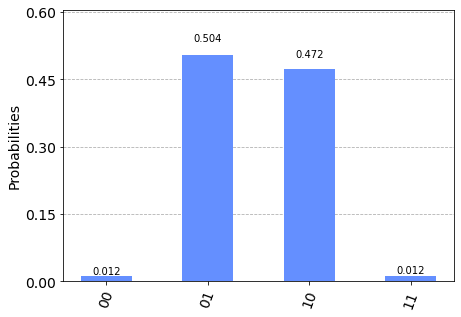

In [12]:
qc = ansatz([1.555, 0.25,  2.106, 3.262])
counts = experiment(qc, 5000)
plot_histogram(counts)

Which indeed they do! This means that our simple ansatz is a good one and the optimisation method is working. Or at least good enough for this task :) 

# 4. Comparing results

Now we want to compare results with different numbers of measurements. The tasks says to look at results with 1, 10, 100 and 1000 measurement at each iteration of the optimiser.

In [21]:
number_of_measurements = 1

params = optimise(initial_params(), 100)
print("Minimiser:", params, "Minimum", objective_function(params))

1 1.0 [5.118 1.551 4.144 5.356] 0.326 1.0 [-1  1 -1 -1]
11 1.0 [5.234 1.484 5.996 5.422] 0.082 0.116 [ 1 -1  1  1]
21 2.414 [4.255 0.505 5.973 6.402] 0.042 0.065 [ 1 -1 -1 -1]
31 2.414 [5.1   1.35  5.96  5.557] 0.026 0.045 [-1 -1  1  1]
41 2.414 [3.948 0.992 5.56  5.157] 0.019 0.035 [ 1  1 -1 -1]
51 1.0 [6.462 2.061 5.873 6.255] 0.014 0.029 [1 1 1 1]
61 2.414 [7.14  1.42  5.898 6.915] 0.011 0.025 [-1 -1 -1  1]
71 2.414 [5.889 0.787 5.878 6.272] 0.009 0.022 [-1  1  1  1]
81 2.414 [5.287 0.186 5.877 5.67 ] 0.008 0.019 [-1  1 -1 -1]
91 2.414 [5.287 0.186 5.877 5.67 ] 0.007 0.017 [-1  1  1 -1]
Minimiser: [ 4.48302396 -0.08578435  5.61741792  4.86561586] Minimum 2.414213562373095


In [22]:
number_of_measurements = 10

params = optimise(initial_params(), 100)
print("Minimiser:", params, "Minimum", objective_function(params))

1 0.728 [5.511 2.639 0.069 0.302] 0.326 1.0 [ 1 -1 -1 -1]
11 1.792 [ 4.585  2.146  0.189 -0.482] 0.082 0.116 [-1 -1 -1 -1]
21 0.0 [4.779 2.945 0.645 0.059] 0.042 0.065 [ 1  1  1 -1]
31 0.816 [4.871 2.735 0.719 0.099] 0.026 0.045 [-1 -1  1 -1]
41 0.277 [ 4.796  2.507  0.668 -0.132] 0.019 0.035 [-1  1 -1 -1]
51 0.985 [ 4.921  2.837  0.67  -0.195] 0.014 0.029 [1 1 1 1]
61 0.277 [ 4.993  3.108  0.428 -0.041] 0.011 0.025 [-1 -1  1  1]
71 0.0 [ 4.93   3.104  0.629 -0.597] 0.009 0.022 [ 1  1  1 -1]
81 0.926 [ 4.581  2.695  0.85  -0.149] 0.008 0.019 [-1 -1  1  1]
91 0.728 [ 4.67   2.618  0.647 -0.152] 0.007 0.017 [-1  1 -1 -1]
Minimiser: [4.6856331  2.70381582 0.49796822 0.36987086] Minimum 0.30860669992418377


In [23]:
number_of_measurements = 100

params = optimise(initial_params(), 60)
print("Minimiser:", params, "Minimum", objective_function(params))

1 0.589 [1.886 2.746 3.081 0.379] 0.326 1.0 [-1  1  1  1]
11 0.172 [ 1.655  2.84   3.193 -0.054] 0.082 0.116 [-1 -1 -1  1]
21 0.228 [1.583 3.149 3.396 0.228] 0.042 0.065 [ 1 -1 -1  1]
31 0.086 [1.563 3.265 3.366 0.061] 0.026 0.045 [ 1  1 -1 -1]
41 0.168 [1.741 3.084 3.337 0.105] 0.019 0.035 [ 1 -1  1 -1]
51 0.287 [1.605 2.939 3.346 0.026] 0.014 0.029 [ 1  1  1 -1]
Minimiser: [ 1.59322964  2.89076391  3.42643949 -0.05299705] Minimum 0.05825929196019302


In [24]:
number_of_measurements = 1000

params = optimise(initial_params(), 60)
print("Minimiser:", params, "Minimum", objective_function(params))

1 0.532 [5.119 2.879 0.192 0.119] 0.326 1.0 [-1  1 -1 -1]
11 0.023 [4.695 3.191 0.468 0.217] 0.082 0.116 [1 1 1 1]
21 0.031 [4.709 3.238 0.53  0.173] 0.042 0.065 [ 1  1 -1 -1]
31 0.043 [4.687 3.28  0.618 0.213] 0.026 0.045 [-1 -1  1 -1]
41 0.046 [4.705 3.21  0.597 0.172] 0.019 0.035 [-1 -1  1  1]
51 0.026 [4.716 3.151 0.617 0.126] 0.014 0.029 [-1  1 -1  1]
Minimiser: [4.73546243 3.14709587 0.67480255 0.11451421] Minimum 0.08231845951447576


It's clear that smaller numbers of measurements make traing extremely difficult, at least with the optimisation technique I've used here. Even with longer training runs a single measurement does not converge and 10 samples struggles. This makes sense because the inherent randomness of the measurement makes the expectation value nearly meaninless and overwhelms the training strategy. 100 and 1000 measurements work well becaue they result in a good estimation of the expectation value.

# 5. Conclusion

This is the first time I've tried variational quantum optimisation and I'm quite pleased with the results. 

They demonstrate clearly that small numbers of measurements negatively affect the output probability estimations and hinder convergence. This fits with my understanding that [standard error](https://en.wikipedia.org/wiki/Standard_error) when estimating expectation values decreases with $1/\sqrt{N}$. 

With this circuit and optimisation scheme used here, it is reasonable to assume that 10 measurements on each iteration is _not_ enough to converge reliably whereas 100 or more measurements gives good convergence. 

In general, convergence is obtained with an minimum around $10^{-1}$ to $10^{-2}$ with this noise model. Even the greater value provides a very good approximation to the target distribution.

Starting the parameters from random or zero initial values seemed to have little impact on the results.

The bonus question I've answered in a [separate notebook](QOSF%20-%20Task%202%20(Bonus%20Question).ipynb).


## Further directions

This notebook concentrates on the relationship of the number of measurements to the performance of the solver. Several other directions for investigation occurred to me during the experiment. Unfortunately time is finite so I'll note them down here:

1. Study **standard error** of the measurement results separately from the training algorithm. The noise model used here is copied from the QisKit documentation. I'd like to understand the different types of noise better and explore the relationship with the expectation value. A simple strategy would be to increase the error probabilities systematically while leaving the circuit unchanged and the number of measurements constant.
<br>

2. Study the performance of **different training algorithms** in the presence of noisy measurements. Convergence is not guaranteed with the basic optimisation method I used and overshoot is quite common. Some trial and error was needed. More advanced [adaptive optimisers](https://qiskit.org/documentation/apidoc/qiskit.aqua.components.optimizers.html) would almost certainly be better for this case. I tried several of those algorithms (one of which is in the Appendix) which provided great results and I'm sure there's a lot more possibilities here. Also there are very many other optimisers from the ML community that might be used. Again it would be good to systematically study the relationship of the different optimisers to the noise model applied.
<br>

3. Look **analytically** at the circuit output to try and understand the effect of noise from a theoretical point of view. The values coming out of the optimiser seem to be close to multiples or fractions of $\pi$ which might be expected for a state this simple.
<br>

4. Use **different distance measures**. The manhatten distance used here is one of the simplest but intuitively it could be exacerbating errors because essentially it's checking dimensions independently. Euclidian distance or cosine difference might be better in this case. It might even be worth exploring true probability distribution distance measures like [Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) or other entropy measures.
<br>

5. And obviously it would be interesting to **change the ansatz** itself to add more layers. The one I've used is the simplest that I could think of and it seems to have given good results. The "variational form" suggested in the [QisKit documentatipon has 3 layers](https://qiskit.org/textbook/ch-applications/vqe-molecules.html#simplevarform) similar to mine. It would be straightforward to repeat the experiment with different configurations. 


# References

**Variational Quantum Eigensolver explained** - Musty Thoughts blog
https://www.mustythoughts.com/variational-quantum-eigensolver-explained

**Simulating Molecules using VQE** - QisKit Tutorials
https://qiskit.org/textbook/ch-applications/vqe-molecules.html

**Noise Models** - QisKit Documentation
https://qiskit.org/documentation/apidoc/aer_noise.html

**Stochastic Optimization** - James C. Spall
https://www.jhuapl.edu/SPSA/Comp_Stat_handbook_2nd-edition_Spall.pdf

**Learning Rate Schedules and Adaptive Learning Rate Methods for Deep Learning** - Suki Lau
https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1

# Appendix 1 - Other training algorithms

## Random search

This simple but far from perfect way to optimise a function is to just sample points around the current one and (usually) move in the direction of the lowest point. The step size (or [learning rate](https://en.wikipedia.org/wiki/Learning_rate)) is usually taken to decrease over the course of the trajectory to narrow in on the minimum. In this code it uses an exponential decay.

The advantage of this method is its simplicity and the fact that it needs a single objective function evaluation at each step. It can however be prone to falling into local minima. The hyperparameters were educated guesses and some trial and error. No magic. It sometimes needs to be run a few times to find a good result.

In [17]:
# Hyperparameters
num_steps = 1000 # Maximum number of steps to take, in other words, the total number of sampled points.
initial_learning_rate = 3.0 # This starts high to try to avoid local minima early in the run.
decay_rate = 8.0/num_steps # Some tunable parameter to reduce the size of the steps over time.
jitter = 0.001 # Probability of accepting a new point even it it is grater then the current one.

def learning_rate(t):
    return math.exp(-decay_rate*t) * initial_learning_rate

params = np.random.rand(4)*2*math.pi
#params = np.zeros(4)
min = objective_function(params)
print(0, np.around(params, 3), round(min,2), initial_learning_rate)

for t in range(1, num_steps):
    delta = np.random.rand(4) * learning_rate(t)
    new = objective_function(params + delta)
    if new < min or random.random() < jitter*min/new:
        print(t, np.around(params,3), round(new,3), round(learning_rate(t),3))
        params = (params+delta)%(2*math.pi)
        min = new

print("Minimiser:", params, "Minimum:", objective_function(params))

0 [4.513 6.097 5.018 3.92 ] 0.3 3.0
203 [4.513 6.097 5.018 3.92 ] 0.298 0.591
456 [4.655 0.322 5.507 3.957] 0.292 0.078
640 [4.709 0.365 5.584 3.961] 0.292 0.018
692 [4.712 0.365 5.595 3.961] 0.272 0.012
Minimiser: [4.71415049 0.37492772 5.60320276 3.96234483] Minimum: 0.3784639535875274


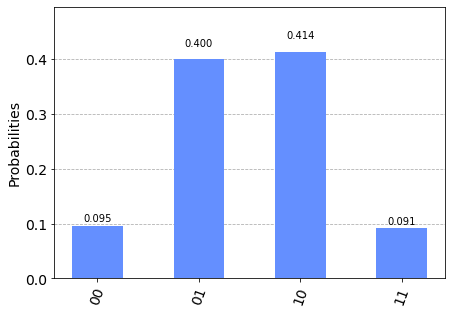

In [18]:
qc = ansatz(params)
counts = experiment(qc, 5000)
plot_histogram(counts)

From my experiments I'd conclude that this method can produce reasonable results but it's unreliable and inefficient compared to other methods.

## An advanced optimiser provided by QisKit

I couldn't resist trying existing optimiser provided by QisKit to compare the performance. In this case, guided by the [QisKit documentation](https://qiskit.org/textbook/ch-applications/vqe-molecules.html#optimization) I use the [COBYLA](https://qiskit.org/documentation/stubs/qiskit.aqua.components.optimizers.COBYLA.html) optimiser. It's very simple to produce the same output as the previous example.

In [19]:
from qiskit.aqua.components.optimizers import COBYLA

params = np.random.rand(4)*2*math.pi

optimizer = COBYLA(maxiter=100, tol=0.0001, disp=True)
ret = optimizer.optimize(num_vars=4, objective_function=objective_function, initial_point=params)

print("Minimiser:", ret[0], "Minimum:", objective_function(ret[0]))

Minimiser: [ 4.74672959 -0.28243272  5.19385771  2.84875356] Minimum: 0.07366127259024492


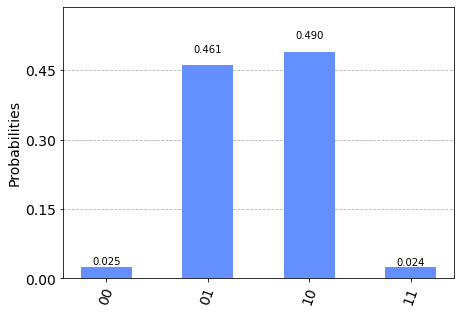

In [20]:
# Obtain the output distribution using the final parameters
qc = ansatz(ret[0])
output_distr = normalise(experiment(qc, 2000))
plot_histogram(output_distr)

This normally gives great results, better than either of the previous methods, and from my experiments, it does it reliably and with fewer steps. This would be the current best option for other projects. It makes it clear that we can do far better than the basic optimisers.